# Assignment 2 

Github repo: https://github.com/c-wejendorp/ComSocSciAssignment2Group1

Contribution: 

Exercise 1,3,4,5: Christoffer 50% Jason 50%. 

Exercise: 2 William 100%


In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.readwrite import json_graph
import json
#import scipy 
import netwulf as nw
from netwulf import visualize
import random
#from scipy.stats import sem, t
import matplotlib.pyplot as plt
import random
import community

from tqdm import tqdm


# Exercise 1) Mixing Patterns and Assortativity.
Let's dig in and try to understand more about the network of Computational Social Scientists using more advanced features. If your network has more than one component, just work on the giant connected component (GCC) in the exercises below. For the exercises below, you shall use the network you built in Week 4.

> The following cell loads the data and displays the total number of nodes in the graph after the giant connected component (GCC) has been extracted. Note we use our own author/paper data set from assignment 1

In [ ]:
f = open('data/graph.json')
data = json.load(f)
G = nx.node_link_graph(data) 
print(f"The number of nodes before the GCC has been found: {len(list(G.nodes))}")
largest_cc = max(nx.connected_components(G), key=len)
# update graph to only include the larget connected component. 
G = G.subgraph(largest_cc)
print(f"The number of nodes after the GCC has been found: {len(list(G.nodes))}")


The number of nodes before the GCC has been found: 2162
The number of nodes after the GCC has been found: 1271


- For each node, compute the fraction of edges that connect to a node that works in the same top field. Find the average value across all nodes:

> In the cell below a function is defined that does exactly that.
When executed on our graph we get the value printed below:

In [ ]:
# loop over all nodes and for each node save the number of edges leading to a node with the same top field.
def fracOfNbrsSameTopic(graph):
    for node in list(graph.nodes):
        nodeTopField=graph.nodes[node]['field']
        counter = 0
        for nbr in graph.adj[node]:
            nbrTopField=graph.nodes[nbr]['field']
            if nodeTopField == nbrTopField:
                counter += 1        
        fracOfNbrsSameTopic=counter/len(graph.adj[node])    
        graph.nodes[node]['fracOfNbrsSameTopic'] = fracOfNbrsSameTopic
        
    _,values = zip(*list(graph.nodes.data('fracOfNbrsSameTopic')))
    return sum(values) / len(list(graph.nodes))
    

print(f"Average fraction of shared field edges:  {np.round(fracOfNbrsSameTopic(G), 2)}")


Average fraction of shared field edges:  0.38


- Create a new graph, with the same nodes and edges, but where the association between nodes and field is shuffled. Compute the measure above for this randomized graph.


> The cell below defines a function that takes a graph as input and extracts all the nodes' "field" attributes and reassigns them randomly. 
If we do this we get the value printed below:     



In [ ]:
def shuffleNodeFields(graph):
    shuffledGraph=graph.copy()    
    key, values = zip(*list(shuffledGraph.nodes.data('field')))    
    values = list(values)    
    random.shuffle(values)    
    newDict = dict(zip(key,values))
    nx.set_node_attributes(shuffledGraph, newDict, name="field")

    return shuffledGraph

print(f"Average fraction of shared field edges of randomized graph:  {np.round(fracOfNbrsSameTopic(shuffleNodeFields(G)), 2)}")


Average fraction of shared field edges of randomized graph:  0.26


- Repeat the point above 100 times (at least). Plot the distribution of the values obtained and compare it with the value you have found for the real graph. Is the chance to connect to a member of the same field significantly higher than it would be by chance?  

> To solve this question we used bootstrapping and sampled 100 times. We then calculated the empirical confidence interval and concluded;
Based on a significance level of 0.05 the chance of connecting to a member of the same field is significantly higher than it would be by chance. 

> The confidence interval for "the fraction of edges that connect to a node that works in the same top field", if the assocations in the graphs are random, are shown below. We have also plotted the distribution for the sampled values with a proper bin-size


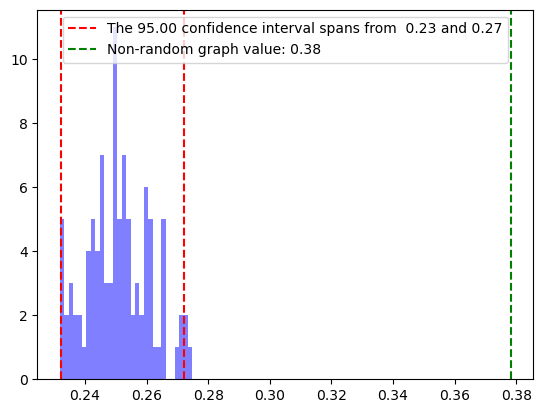

In [ ]:
n = 100
avgValues = [fracOfNbrsSameTopic(shuffleNodeFields(G)) for i in range(n)]
#compute the emperical confidence interval
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(avgValues, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(avgValues, p))
num_bins = 30
n, bins, patches = plt.hist(avgValues, num_bins, facecolor='blue', alpha=0.5)
#plot the confidence interval
plt.axvline(x=lower, color='r', linestyle='--',label='The %.2f confidence interval spans from  %.2f and %.2f' % (alpha*100, lower, upper))
plt.axvline(x=upper, color='r', linestyle='--')
plt.axvline(x=fracOfNbrsSameTopic(G), color='g', linestyle='--',label=f"Non-random graph value: {fracOfNbrsSameTopic(G):.2f}")
plt.legend()
plt.show()

- Compute the assortativity coefficient with respect to author's field. How do you interpret the value you obtain? Important: here I do not want you to use the NetworkX implementation, but rather to implement your own version of the measure.


> We found r = 0.14. Our interpretation of this is the following; As the value of r is greater than 0, the graph is somewhat assortative with respect to the attribute "field". This means ths authors' whose top fields are the same tend to work together on papers.   



In [ ]:
#we have the following field attributes in our graph
nodefield = nx.get_node_attributes(G, "field")
fields=list(set([nodefield[node] for node in G.nodes]))
print(f"The author fields in our graph are: {fields}")

# create the mixing matrix

# Initialize the mixing matrix
n = len(fields)
mixing_matrix = np.zeros((n, n))

# Compute the fraction of edges between nodes with different attributes
for edge in G.edges():
    i = fields.index(nodefield[edge[0]])
    j = fields.index(nodefield[edge[1]])
    mixing_matrix[i][j] += 1

total_edges = G.number_of_edges()
mixing_matrix = mixing_matrix / total_edges

#compute the row and column sums
row_sums = np.sum(mixing_matrix, axis=1)
col_sums = np.sum(mixing_matrix, axis=0)

numerator = np.sum(np.diag(mixing_matrix)) - np.sum(row_sums*col_sums)
denominator= 1 - np.sum(row_sums*col_sums)

assortativity =numerator/denominator
# print our calculation of the assortativity coefficient is
print(f"The assortativity coefficient calculated is: {assortativity}") 



The author fields in our graph are: ['Political Science', 'Geology', 'Economics', 'Philosophy', 'Sociology', 'Agricultural And Food Sciences', 'Chemistry', 'Education', 'Business', 'History', 'Mathematics', 'Engineering', 'Physics', 'Law', 'Psychology', 'Environmental Science', 'Linguistics', 'Materials Science', 'Biology', 'Art', 'Medicine', 'Computer Science']
The assortativity coefficient calculated is: 0.13853874342585218


- Is the graph assortative with respect to the degree? (e.g. do high-degree scientists tend to link to other high-degree scientists, and low-degree scientists to other low-degree scientists?). Provide an interpretation of your answer.

> Here we have used the NetworkX implementation and found the assortativity coefficient with respect to degree to be -0.079. As this value is smaller than 0, it indicates that there could be disassortative mixing. This means that nodes with different degree values tend to be connected to each other. One example of how this would occur is if teachers / researchers at universities write papers with their students, then the teacher node has a high degree and the stundent node has a low degree. 

In [ ]:
q=nx.degree_assortativity_coefficient(G)
print(f"The assortativity coefficient with respect to degree is: {np.round(q, 2)}")

The assortativity coefficient with respect to degree is: -0.08


### Exercise 2) Zachary's karate club


### 2.1

Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). 
Set the color of each node based on the club split (the information is stored as a node attribute).

In [8]:
G = nx.karate_club_graph()


color_dict = {'Mr. Hi': '#1f77b4', 'Officer': '#ff7f0e'}
for n in G.nodes():
    G.nodes[n]['color'] = color_dict[G.nodes[n]['club']]

#uncomment for visualization in browser
#nw.visualize(G)

![Alt text](data/networkKarate.png)

### 2.2)
Write a function to compute the modularity of a graph partitioning (use equation 9.12 in the book). 
The function should take a networkX Graph and a partitioning as inputs and return the modularity.

In [9]:
def modularity(G, partition):
    # initialize variables
    A = nx.adjacency_matrix(G)
    m = G.number_of_edges()
    Q = 0
    
    # loop over all pairs of nodes
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            # get the community assignments of the two nodes
            ci = partition[i]
            cj = partition[j]
            
            # compute the modularity contribution of this pair of nodes
            delta_Q = (A[i,j] - (G.degree(i) * G.degree(j)) / (2*m)) * (ci == cj)
            
            # add the contribution to the modularity
            Q += delta_Q
            
    # normalize the modularity by dividing by the total number of edges
    Q = Q / (2*m)
    
    return Q

### 2.3)
Explain in your own words the concept of modularity.

Modularity is a measure of the strength of the division of a network into groups or communities. 
It is a way to quantify how well a given partition of nodes into communities captures the structure of the network.

In a modular network, the nodes within a community tend to be more densely connected to each other than to nodes in other communities. 
Modularity measures the extent to which this is true for a given partition of the network. 
A high modularity value indicates that the partition is a good fit for the network, meaning that the nodes within each community are more densely connected to each other than to nodes in other communities.

### 2.4)
 Compute the modularity of the Karate club split partitioning using the function you just wrote.

In [10]:
# get the club split partitioning
partition = nx.get_node_attributes(G, 'club')

# compute the modularity of the partitioning
Q = modularity(G, partition)

# print the modularity
print('Modularity of karate club split partitioning:', Q)

C:\Users\Christoffer\AppData\Local\Temp\ipykernel_19784\2146314428.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


Modularity of karate club split partitioning: 2.1402859960552245


## 2.5)
We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. 
To do so, we will implement the double edge swap algorithm. 

In [11]:
def double_edge_swap(G, N):
    # make a copy of the graph
    G_new = G.copy()
    
    # repeat N times
    for i in range(N):
        # choose two edges at random
        nodes = list(G.nodes())
        u, v = random.sample(nodes, 2)
        neighbors_u = list(G.neighbors(u))
        x, y = random.sample(neighbors_u, 2)
        
        # check if the two new edges already exist
        if not G_new.has_edge(u, y) and not G_new.has_edge(x, v):
            # perform the double edge swap
            G_new.remove_edge(u, v)
            G_new.remove_edge(x, y)
            G_new.add_edge(u, y)
            G_new.add_edge(x, v)
            
    return G_new

2.6 Double check that your algorithm works well, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.

In [13]:
# generate a new randomized graph
G_rand = double_edge_swap(G, 2*G.number_of_edges())

# check that the degree of each node is the same in both graphs
for node in G.nodes():
    assert G.degree(node) == G_rand.degree(node)


ValueError: Sample larger than population or is negative

2.7 Create 1000 randomized version of the Karate Club network using the double edge swap algorithm you wrote in step 5. 
For each of them, compute the modularity of the "club" split and store it in a list.

In [14]:
# generate 1000 randomized versions of the karate club graph
N = 1000
G_rand_list = [double_edge_swap(G, 2*G.number_of_edges()) for i in range(N)]

# compute the modularity of the club split for each of the 1000 randomized versions
modularity_rand = [compute_modularity(G_rand, club_dict) for G_rand in G_rand_list]

ValueError: Sample larger than population or is negative

2.8 Compute the average and standard deviation of the modularity for the random network.

In [15]:
modularity_mean = sum(modularity_rand) / N
modularity_std = ((sum((modularity - modularity_mean)**2 for modularity in modularity_rand)) / N)**0.5

print("Average modularity of randomized versions:", modularity_mean)
print("Standard deviation of modularity of randomized versions:", modularity_std)

NameError: name 'modularity_rand' is not defined

2.9 Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use axvline).

In [16]:
#plot the distribution of the modularity for the randomized versions
plt.hist(modularity_rand, bins=20, alpha=0.5, density=True)
plt.axvline(modularity_actual, color='r', linestyle='--', label='Actual modularity')
plt.xlabel('Modularity')
plt.ylabel('Density')
plt.legend()
plt.show()

NameError: name 'modularity_rand' is not defined

2.10 Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? 
#What is the reason why we preserved the nodes degree?

The distribution of modularity values for the randomized versions is centered around 0, with a few values slightly positive and negative. 
The actual modularity value of the club split partitioning is quite high compared to the randomized versions, which suggests that the club split is a good partitioning of the network.

We preserved the node degrees in the randomized versions of the network because the degree distribution is an important feature of many real-world networks. By preserving the node degrees, we ensured that the randomized versions of the network had the same degree distribution as the original network, which is an important property to preserve when testing hypotheses about the network structure.

2.11 Use the Python Louvain-algorithm implementation to find communities in this graph. 
Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? 
What does this comparison reveal?

In [17]:
# Find the communities using the Louvain algorithm
partition = community.best_partition(G)

# Compute the modularity
modularity = community.modularity(partition, G)

print("Modularity found by Louvain algorithm:", modularity)

Modularity found by Louvain algorithm: 0.44490358126721763


The modularity value found by the Louvain algorithm is lower than what we found above for the club split partitioning.
This comparison reveals that the Louvain algorithm was not able to find a partitioning of the network that was as good 
as the club split partitioning in terms of modularity.

2.12 Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix D with dimension (2 times A),  where A is the number of communities found by Louvain. 
We set entry D(i,j) to be the number of nodes that community i has in common with group split j. 
The matrix D is what we call a confusion matrix. Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [18]:
# get the community assignments from the Louvain algorithm
louvain_communities = community.best_partition(G)

# create a dictionary that maps node IDs to club labels
club_dict = nx.get_node_attributes(G, 'club')

# get the number of communities found by Louvain
num_louvain_communities = len(set(louvain_communities.values()))

# create a matrix to hold the confusion matrix
D = np.zeros((num_louvain_communities, 2))

# fill in the confusion matrix
for i, c in enumerate(set(louvain_communities.values())):
    louvain_nodes = [n for n in louvain_communities if louvain_communities[n] == c]
    for j, club_label in enumerate([0, 1]):
        club_nodes = [n for n in club_dict if club_dict[n] == club_label]
        D[i,j] = len(set(louvain_nodes).intersection(club_nodes))

print(D)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


Looking at the confusion matrix, we can see that most of the nodes in the original club split partitioning (club 1 and club 2) are well-separated in the communities detected by the Louvain algorithm. Community 0 corresponds almost entirely to club 2, while community 1 corresponds mostly to club 1.

However, there is also some degree of mixing between the communities and the club split partitioning. 
Some nodes from club 1 are found in community 0, while some nodes from club 2 are found in community 1. 
This suggests that the community structure found by the Louvain algorithm is not a perfect match to the original club split partitioning, but it does capture some of its structure.

# Exercise 3: Community detection on the network of Computational Social Scientists.
Some new import statements.
The graph used is naturally the same as in exercise 1.

In [19]:
f = open('data/graph.json')
data = json.load(f)
G = nx.node_link_graph(data) 
largest_cc = max(nx.connected_components(G), key=len)
# update graph to only include the larget connected component. 
G = G.subgraph(largest_cc)
print(f"The number of nodes after the GCC has been found: {len(list(G.nodes))}")


The number of nodes after the GCC has been found: 1271


- Use the Python Louvain-algorithm implementation to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0?
> We found 30 communities. The modularity is 0.899, which is significantly different than 0. Modularity measures <> and is found within the range [-1/2, 1]. Thus, this partition is well done. 

In [20]:
# Find all communities in the graph
partition = community.best_partition(G)  # This returns inconsistent results. TODO: FORCE 30 COMMUNITIES
num_communities = len(set(partition.values()))

# Number of communities
print(f"Number of communities found: {num_communities}")
_, counts = np.unique(list((partition.values())), return_counts=True)

# Community sizes
print("\nCommunity : Count")
kek = 4
for i in range(0, len(counts), kek):
    for com, c in zip(list(range(i, i+kek)), counts[i:i+kek]):
        print(f"{com} : {c} ", end="| ")
    print()


# Modularity
modularity = community.modularity(partition, G)
print(f"\nThe modularity of the graph is: {modularity}")

Number of communities found: 31

Community : Count
0 : 27 | 1 : 29 | 2 : 72 | 3 : 20 | 
4 : 30 | 5 : 29 | 6 : 52 | 7 : 46 | 
8 : 47 | 9 : 80 | 10 : 22 | 11 : 29 | 
12 : 17 | 13 : 42 | 14 : 120 | 15 : 86 | 
16 : 39 | 17 : 41 | 18 : 30 | 19 : 47 | 
20 : 29 | 21 : 76 | 22 : 18 | 23 : 17 | 
24 : 31 | 25 : 41 | 26 : 37 | 27 : 34 | 
28 : 18 | 29 : 36 | 30 : 29 | 

The modularity of the graph is: 0.898879394939209


- Visualize the network, using netwulf (see Week 5). This time assign each node a different color based on their community. Describe the structure you observe.
- Make sure you save the assignment of authors to communities.
> We see some clear communities. As examples we have the yellow community at the top of graph. The brown /reddish community at the right side of the graph and the purple/pink community at the bottom of thr graph. In  the yellow and pink community mentioned there are a single person who has worked with almost the rest of their community. 

In [21]:
nx.set_node_attributes(G, partition, name="group")  # group controls color
#visualize(G)

![Alt text](data/networkCom.png)

# Exercise 4: TF-IDF and the Computational Social Science communities.

The goal for this exercise is to find the words characterizing each of the communities of Computational Social Scientists.
> Student critic: Calculate TF-IDF for each word in each community. THEN, find top 10 lists across community. As you'll see, there will be some redundancy, because we strictly follow your instructions. SUGGESTION: For better coding practice, have us write specific functions that we can call in the main code to answer your questions.

## 4.1) Check wikipedia for TF-IDF.
Explain in your own words the point of TF-IDF. What does TF and IDF stand for?
> Short for `term frequency–inverse document frequency`, it is a method applied in information retrieval (IR) that down weighs frequent terms. This is important, because word frequencies decrease logarithmically by rank cf. Zipf's law, and we want to avoid that the most frequent words dominate the analysis. 


## 4.2) Community abstracts
Now, we want to find out which words are important for each community, so we're going to create several **large documents, one for each community**. Each document includes all the tokens of abstracts written by members of a given community.

- Consider a community c
- Find all the abstracts of papers written by a (ALL) member(S) of community c.
- Create a long array that stores all the abstract tokens
- Repeat for all the communities.

> This is quite the task. For completeness the tokenized abstracts are genereated here with code from week 7.

In [22]:
# Tokenizer code written in week7
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

urls = '\S+www\S+\w'    # remove urls by searching for www
symbols = '[^\w\s]'     # remove punctuation
numbers = '\d+'         # remove numbers
stop_words = stopwords.words('english')
ps = PorterStemmer()    # Stemming

def tokenize(text):
    if text is None:
        return None
    text = text.lower()
    text = re.sub(fr'{symbols}|{urls}|{numbers}','',text)
    text = [ps.stem(word) for word in text.split() if word not in stop_words] 
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Christoffer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
import pickle  # HACK DELETE LATER

# abstracDataSet contains paperId and their abstracts
# paperDataSet contains paperId	title	year	externalId.DOI	citationCount	fields	authorIds	author_field

with open('data/paperAbstractDataSet.pkl', 'rb') as f:
    abstractDataSet = pickle.load(f)
abstractDataSet=abstractDataSet.drop_duplicates(subset=['papersId'])

with open('data/ccs_papers.pkl', 'rb') as f:
    paperDataSet = pickle.load(f)

paperDataSet.shape
# 0.5 min

(969493, 8)

> We need access to the papers written by the authors in the graph. We have a paperDataSet that has up to a million entrees. This is cut down by filtering out papers where none of the contributors exists in the graph. The `explode` command is used, because the `authors` column is a list of authors.

In [24]:
temp = dict(G.nodes)
valid = paperDataSet['authorIds'].apply(lambda x: any(elem in temp for elem in x))
papers = paperDataSet[valid]         # Filter out papers with authors not in graph
papers = papers.explode('authorIds') # Explode the authorIds column

> Now collect all unique paperIDs for each community using sets.

In [25]:
communityPaperIDs = [set() for _ in range(num_communities)]
for node in tqdm(G.nodes(data=True)):
    author = node[0]
    writtenPapers=papers[papers["authorIds"].isin([author])]["paperId"]
    community = partition[author]
    communityPaperIDs[community].update(writtenPapers)

100%|██████████| 1271/1271 [00:04<00:00, 280.56it/s]


> With the paperIDS, the corresponding abstracts are found in the abstracts dataset. 
The abstracts are then tokenized and stored in a list for each community.

In [26]:
corpus = [[] for _ in range(len(communityPaperIDs))]


for i, paperIDs in tqdm(enumerate(communityPaperIDs)):
    abstracts=abstractDataSet[abstractDataSet["papersId"].isin(paperIDs)]["papersAbstract"]

    abstracts = abstracts.dropna()    # Drop all rows with None values
    abstracts.apply(lambda x: corpus[i].extend(tokenize(x)))

# 7 minutes

31it [02:53,  5.60s/it]


## 4.3) Calculate TF
Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within the top 5 communities (by number of authors).

> First isolate the tokens of the top 5 communities. Then Cacluate TF for each token in each community.

In [27]:
# First find top 5 comminutes by size
top5communities = np.argsort(counts)[-5:][::-1]
# top5tokens = [communityTokens[x] for x in top5communities]
print("Top 5 communities:", top5communities)
corpus5 = [corpus[x] for x in top5communities]


Top 5 communities: [14 15  9 21  2]


In [28]:
# Calculate the tf for each community
from collections import Counter
TF5 = [Counter(tokens) for tokens in corpus5]  # non-normalized term frequency

# Normliaze the tf
for i, tf in enumerate(TF5):
    for key in tf:
        tf[key] /= len(corpus5[i])

In [29]:
# Find the top 5 terms for each community
top5terms = [tf.most_common(5) for tf in TF5]
top5terms = [list(zip(*terms))[0] for terms in top5terms] # Extract the terms

print("Top 5 terms for each community:")
for i, terms in zip(top5communities, top5terms):
    print(f"{i}) : {terms}")

Top 5 terms for each community:
14) : ('use', 'user', 'social', 'studi', 'data')
15) : ('use', 'user', 'social', 'data', 'design')
9) : ('use', 'social', 'data', 'inform', 'user')
21) : ('model', 'use', 'algorithm', 'data', 'inform')
2) : ('network', 'use', 'social', 'data', 'model')


- Describe similarities and differences between the communities.
> Similarities include **use, user, social, data, and inform**. 

> Differences include **studi, model, design, and algorithm**.

- Why aren't the TFs not necessarily a good description of the communities?
> TF alone does not consider the significance of a word, i.e. words that in general appear often will unfailry score high. 

- Next, we calculate IDF for every word.
> The IDF is calculated where it is assumed that each community has one document, such that N = number of communities. First determine the number of communities that contain a given word. Then calculate the IDF for each word.

$$
IDF = \log\left(\frac{N}{n}\right),
$$
where $N$ is the total number of communities and $n$ is the number of communities that contain the word.

In [30]:
# Compute IDF for every term
IDF5 = Counter()
N = len(corpus5)

# For each term, count the number of communities that contain it
for c in corpus5:
    for term in set(c):
        IDF5[term] += 1

# Compute the IDF
IDF5 = {key: np.log(N / value) for key, value in IDF5.items()}

- What base logarithm did you use? Is that important?
> Natural logirithm. Not important, we are just interested in projecting onto the log scale.

## 4.4) TF-IDF
We're ready to calculate TF-IDF. Do that for the top 9 communities (by number of authors). Then for each community:

- List the 10 top TF words

In [31]:
# First find top 9 communities by size
N = 9
top9communities = np.argsort(counts)[-N:][::-1]
print(f"Top {N} communities:", top9communities)
corpus9 = [corpus[x] for x in top9communities]

# Calculate the tf for each community
from collections import Counter
TF9 = [Counter(tokens) for tokens in corpus9]  # non-normalized term frequency

# Normliaze the tf
for i, tf in enumerate(TF9):
    for key in tf:
        tf[key] /= len(corpus9[i])

top10terms9 = [tf.most_common(10) for tf in TF9]
top10terms9 = [list(zip(*terms))[0] for terms in top10terms9] # Extract the terms

print("Top 10 terms for each community:")
for i, terms in zip(top9communities, top10terms9):
    print(f"{i}) : {terms}")

Top 9 communities: [14 15  9 21  2  6 19  8  7]
Top 10 terms for each community:
14) : ('use', 'user', 'social', 'studi', 'data', 'research', 'work', 'system', 'inform', 'model')
15) : ('use', 'user', 'social', 'data', 'design', 'system', 'research', 'inform', 'studi', 'commun')
9) : ('use', 'social', 'data', 'inform', 'user', 'algorithm', 'studi', 'time', 'model', 'result')
21) : ('model', 'use', 'algorithm', 'data', 'inform', 'result', 'problem', 'show', 'effect', 'learn')
2) : ('network', 'use', 'social', 'data', 'model', 'system', 'mobil', 'inform', 'studi', 'result')
6) : ('network', 'use', 'data', 'model', 'social', 'user', 'inform', 'studi', 'result', 'commun')
19) : ('network', 'use', 'user', 'data', 'system', 'model', 'differ', 'studi', 'result', 'perform')
8) : ('use', 'user', 'network', 'data', 'system', 'model', 'social', 'inform', 'result', 'studi')
7) : ('use', 'data', 'model', 'propos', 'social', 'method', 'user', 'network', 'result', 'studi')


- List the 10 top TF-IDF words


In [32]:
IDF9 = Counter()
N = len(corpus9)

# For each term, count the number of communities that contain it
for c in corpus9:
    for term in set(c):
        IDF9[term] += 1

# Compute the IDF
IDF9 = {key: np.log(N / value) for key, value in IDF9.items()}

# Compute TF-IDF for each community
TFIDF9 = [Counter() for _ in range(N)]
for i, tf in enumerate(TF9):
    for term in tf:
        TFIDF9[i][term] = tf[term] * IDF9[term]

# Extract the top 10 terms for each community
top10terms9 = [tf.most_common(10) for tf in TFIDF9]
top10terms9 = [list(zip(*terms))[0] for terms in top10terms9] # Extract the terms

print("Top 10 terms for each community:")
for i, terms in zip(top9communities, top10terms9):
    print(f"{i}) : {terms}")



Top 10 terms for each community:
14) : ('dram', 'codemix', 'phish', 'streamit', 'transliter', 'mooc', 'ictd', 'bangalor', 'bitwis', 'rbac')
15) : ('earthworm', 'microfilm', 'psl', 'searcher', 'ubuntu', 'vape', 'odk', 'hcai', 'cscw', 'spreadsheet')
9) : ('corros', 'maritim', 'gull', 'childbear', 'calv', 'hydraul', 'childless', 'anod', 'eubalaena', 'electrodeposit')
21) : ('bidder', 'ç', 'estimand', 'dpp', 'actr', 'multirobot', 'multiag', 'ewa', 'pprl', 'regret')
2) : ('mbb', 'tota', 'deli', 'sociometr', 'saper', 'multiag', 'aria', 'latrin', 'deaggreg', 'inod')
6) : ('smallsid', 'eip', 'dasymetr', 'knot', 'ghsl', 'areal', 'corex', 'hashcod', 'tvg', 'ssg')
19) : ('bci', 'eeg', 'cortic', 'pbase', 'neuroelectr', 'hyperscan', 'theta', 'neurophysiolog', 'cerebr', 'armenian')
8) : ('bitext', 'diacrit', 'mmorpg', 'rumour', 'uma', 'gaminganywher', 'dnssec', 'gfg', 'cem', 'apg')
7) : ('reid', 'spancor', 'influenzanet', 'giorno', 'dtd', 'adblock', 'antiadblock', 'samoa', 'queryflow', 'nespol')


- List the top 3 authors (by degree)

In [33]:
# Determine degree of all nodes
import pandas as pd
degree = dict(G.degree())
nx.set_node_attributes(G, degree, name="degree") 
df=pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

# Extract top 3 authors for each community by degree
top3authors = []
for i in range(num_communities):
    authors = [node for node in G.nodes(data=True) if node[1]['group'] == i]
    top3authors.append(sorted(authors, key=lambda x: x[1]['degree'], reverse=True)[:3])
    # Extract their names
    top3authors[i] = [x[1]['name'] for x in top3authors[i]]

print("Top 3 authors for each community:")
for i in top9communities:
    authors = top3authors[i]
    print(f"{i}) : {authors}")

Top 3 authors for each community:
14) : ['Joyojeet Pal', 'Priyanka Chandra', 'Vaishnav Kameswaran']
15) : ['Munmun De Choudhury', 'Sarita Yardi Schoenebeck', 'Neha Kumari Pawan Kumar']
9) : ['Ingmar G. Weber', 'Masoomali Fatehkia', 'Ridhi Kashyap']
21) : ['Duncan J. Watts', 'Markus M. Mobius', 'Sharad Chandra Goel']
2) : ['Alexander Sandy Pentland', 'Iyad Rahwan', 'Johannes Bjelland']
6) : ['Michael D. Conover', "M'arton Karsai", 'Filippo Menczer']
19) : ['Daniele Quercia', 'Vito Latora', 'Luca Maria Aiello']
8) : ['Haewoon Kwak', 'Krishna P. Gummadi', 'Meeyoung Cha']
7) : ['Yelena A Mejova', 'Kyriaki Kalimeri', 'Daniela Paolotti']


- Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?
> Looking at the output from the code just before the one above... Yes! As opposed to before where there was large overlap, now are exclusive to each community. 

# Exercise 5: The Wordcloud

It's time to visualize our results!

- Now, create word-cloud for each community. Feel free to make it as fancy or non-fancy as you like.
- Make sure that, together with the word cloud, you print the names of the top three authors in each community (see my plot above for inspiration).
> First compute the TF-IDF for each word in each community. Then, extract top three authors and finally create a wordcloud for each community.

In [34]:
# Calculate the tf for each community
N = len(corpus)
TF = [Counter(tokens) for tokens in corpus]  # non-normalized term frequency

# Normliaze the tf
for i, tf in enumerate(TF):
    for key in tf:
        tf[key] /= len(corpus[i])

# Compute IDF for every term
IDF = Counter()
N = len(corpus)

# For each term, count the number of communities that contain it
for c in corpus:
    for term in set(c):
        IDF[term] += 1

# Compute the IDF
IDF = {key: np.log(N / value) for key, value in IDF.items()}

# Compute TF-IDF for each community
TF_IDF = [Counter() for _ in range(N)]
for i, tf in enumerate(TF):
    for term in tf:
        TF_IDF[i][term] = tf[term] * IDF[term]



In [35]:
# Extract the top 3 authors (by degree) for each community
top3authors = []
for i in range(num_communities):
    authors = [node for node in G.nodes(data=True) if node[1]['group'] == i]
    top3authors.append(sorted(authors, key=lambda x: x[1]['degree'], reverse=True)[:3])
    top3authors[i] = [x[1]['name'] for x in top3authors[i]]  # Extract their names

texts = [" ".join(TF_IDF[i]) for i in range(num_communities)]

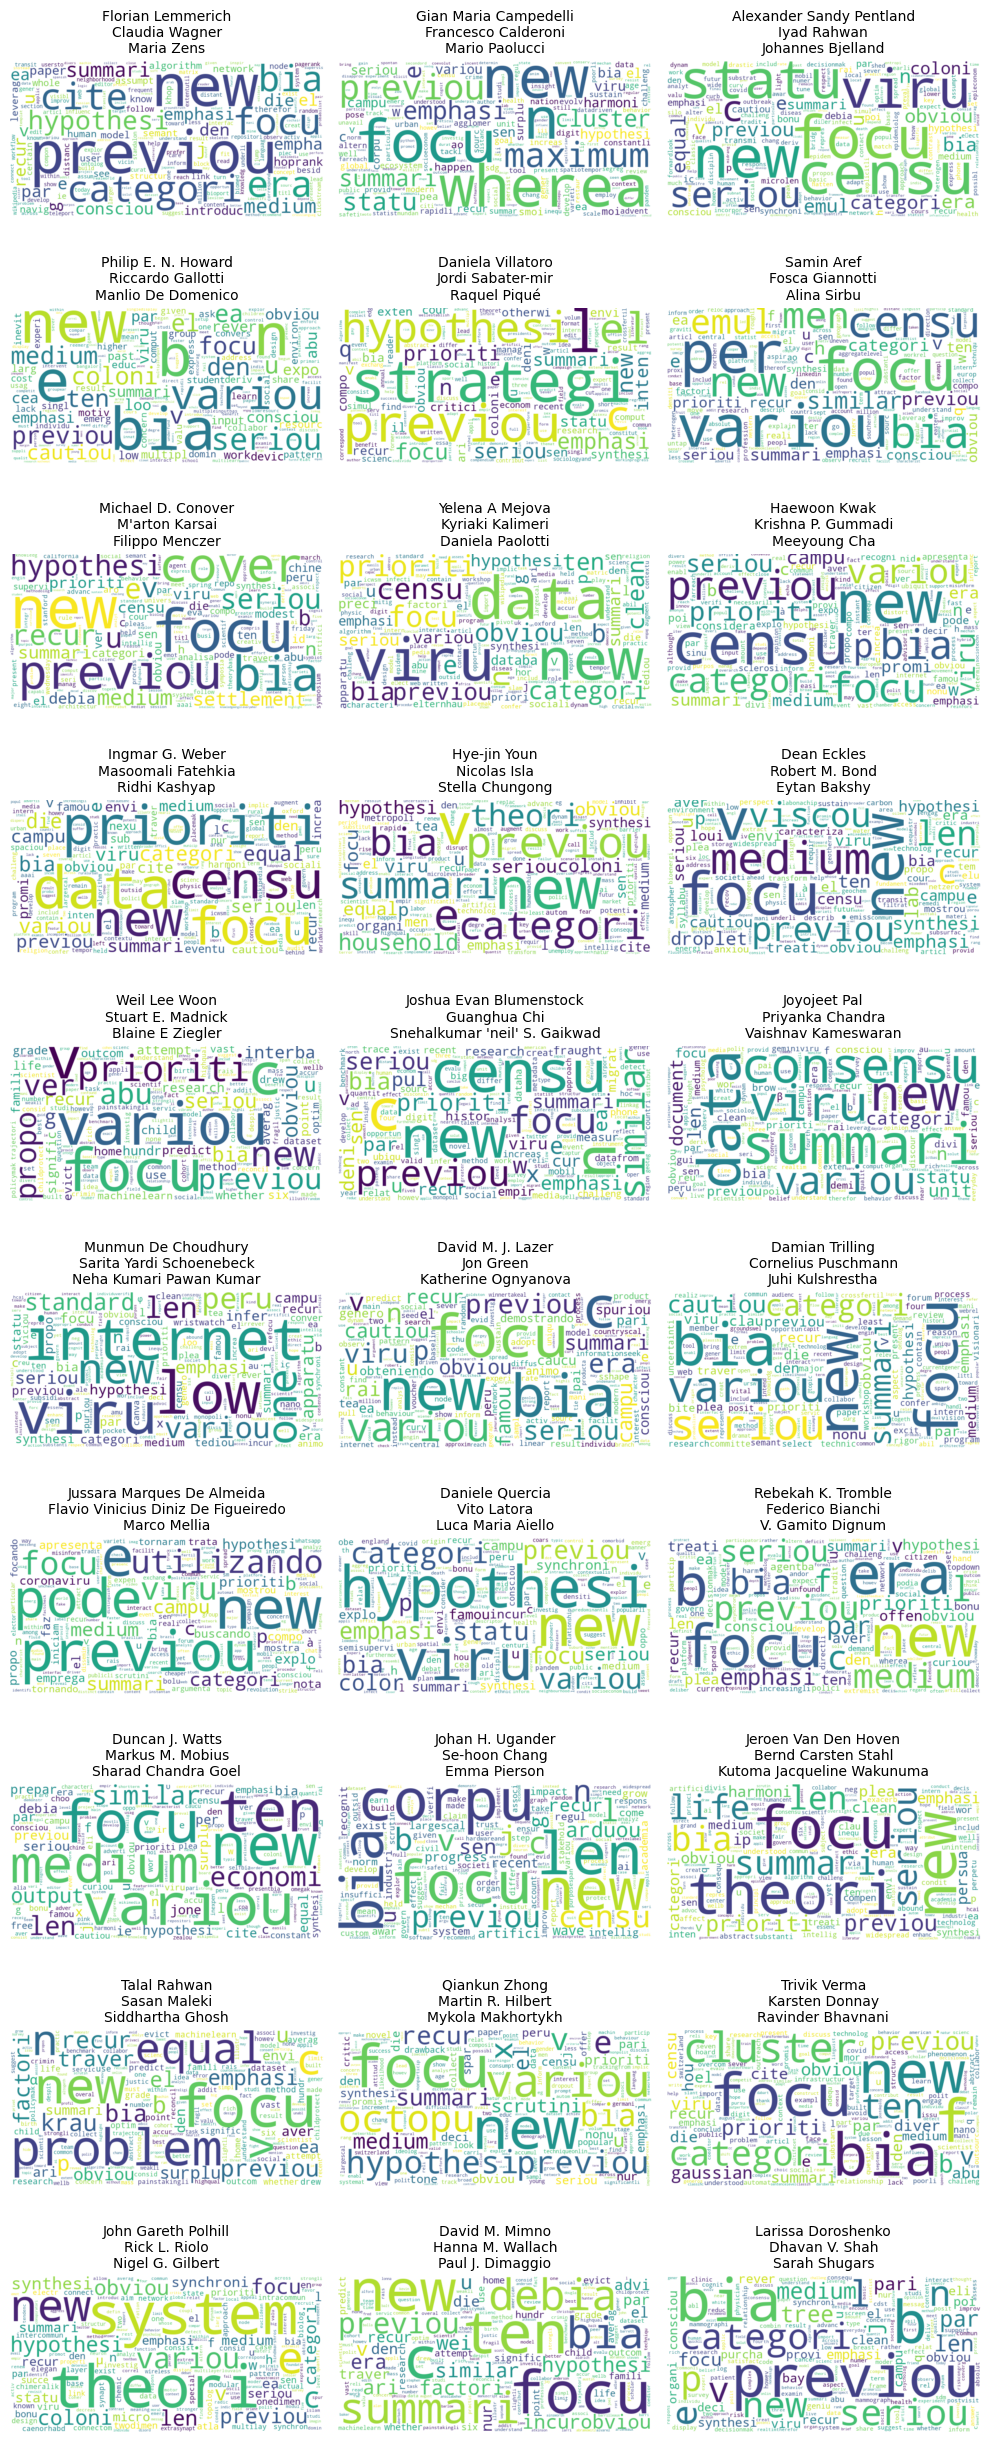

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Generate wordclouds for each community with suplots
fig, axes = plt.subplots(10, 3, figsize=(10, 25))
for i, ax in enumerate(axes.flatten()):
    text = texts[i]
    wordcloud = WordCloud(width=800, height=400, max_font_size=150, background_color="white").generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title("\n".join(top3authors[i]), fontsize=10)
plt.tight_layout()
plt.show()

# 1 minutes

- Comment on your results. What can you conclude on the different sub-communities in Computational Social Science?
> The wordclouds are quite nice. However, we haven't undone the stemming. This results in incomprehensible words and personlly we can't dissect much from it. Despite confirmation bias, it looks like each community deals with different branches of science. 
- Look up online the top author in each community. In light of your search, do your results make sense?
> #maybe just delete this question?